
# AI vs IA
---

#### Groupe 12

Ce notebook contient notre travail pour le sujet **AI vs IA** du hackaton **IA Data Hack**<br><br>
La structure du notebook est la suivante:
- Compréhension du sujet
- Analyse et transformation de la donnée
- Benchmark de différents modèles de machine learning
- Optimisation du meilleur modèle de machine learning
- Modèles de deep learning
- Conclusion

Nous utilisons la librairie ```scikit-learn``` pour une partie du benchmark, qui s'exécute seulement sur CPU, donc ça prend beaucoup de temps d'entraîner les différents modèles.<br>
Il y aura le commentaire ```EXECUTION LONGUE``` sur certaines parties du benchmark très longue à exécuter, vous pouvez consulter le notebook sous format HTML dans le repository Github pour voir directement les résultats !

## Compréhension du sujet
---

Le sujet de ce hackaton est, comme dit précedemment, **AI vs IA**. A partir d'un texte, nous devons identifier si ce texte a été écrit par un **humain** ou par une **IA**.<br>
Ainsi, on considère ce problème comme un problème de **classification**, plus précisément un problème de **classification binaire**. La classification binaire est un problème commun en intelligence artificielle, qui demande des modèles de ***machine learning*** ou de ***deep learning***. Nous allons utiliser ces 2 types de modèles et les comparer dans notre benchmark pour sélectionner le plus adapté.<br>
Pour un problème de classification binaire, nous utilisons la fonction de perte ```binary cross entropy```, qui est la plus appropriée, et qui se calcule de la façon suivante:

$$
BCE = -y \cdot \log(p) - (1 - y) \cdot \log(1 - p)
$$

Où:
- *y* est le vrai label (0 - IA ou 1 - Humain)
- *p* est la probabilité prédite (entre 0 et 1)


## Analyse et transformation de la donnée
---

### Importation des librairies

In [57]:
import os
import pandas as pd
import s3fs
import zipfile
import numpy as np
import time
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score,recall_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

#### Récupération du dataset sur AWS

In [58]:
# Création d'un object filesystem s3
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [3]:
file_path = "data.csv"

# Téléchargement des données dans le service
fs.download("civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv", file_path)

[None]

In [59]:
# Création d'un dataframe à partir du fichier csv
df = pd.read_csv(file_path).drop(['src'], axis=1)


### Etude de la longueur des textes



In [60]:
# Création d'un dataframe pour étudier la longueur des textes du dataframe
text_df = pd.DataFrame(df["label"])
text_df['text_length'] = df["text"].apply(len)
print("Longueur moyenne des textes: ", int(text_df['text_length'].mean()))
print("Longueur minimum des textes: ", text_df['text_length'].min())
print("Longueur maximum des textes: ", text_df['text_length'].max())

Longueur moyenne des textes:  1230
Longueur minimum des textes:  24
Longueur maximum des textes:  63723


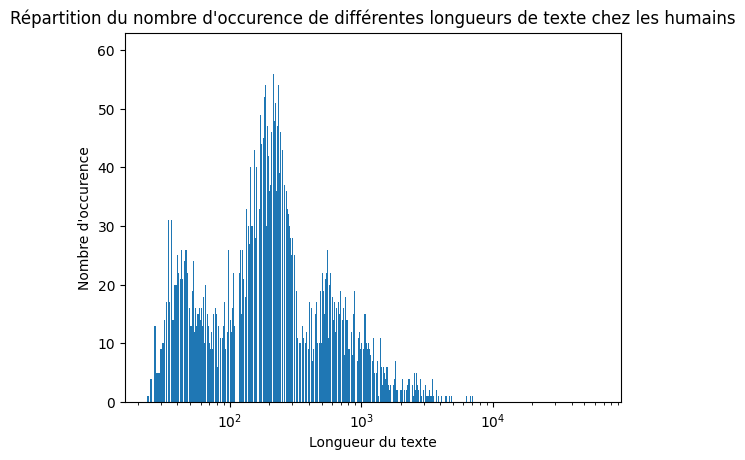

In [61]:
values, count = np.unique(text_df[text_df["label"] == 1]["text_length"].values, return_counts=True)
plt.bar(values, count)
plt.xscale("log")
plt.xlabel("Longueur du texte")
plt.ylabel("Nombre d'occurence")
plt.title("Répartition du nombre d'occurence de différentes longueurs de texte chez les humains")
plt.show()

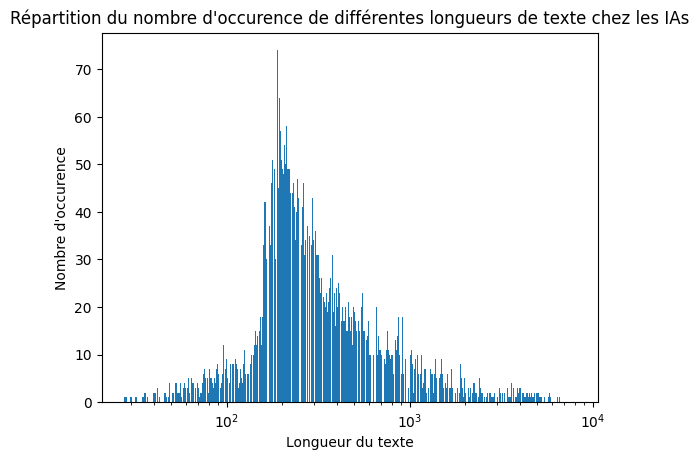

In [62]:
values, count = np.unique(text_df[text_df["label"] == 0]["text_length"].values, return_counts=True)
plt.bar(values, count)
plt.xscale("log")
plt.xlabel("Longueur du texte")
plt.ylabel("Nombre d'occurence")
plt.title("Répartition du nombre d'occurence de différentes longueurs de texte chez les IAs")
plt.show()

On remarque que la longueur des textes écrits par les humains est plus étendue que celle des textes générées par des IAs, qui semble être centrée autour de 200.

### Occurences de mots ayant des fautes d'ortographe

La liste des mots bannis a été établi selon les fautes les plus récurrentes dans la langue anglaise.

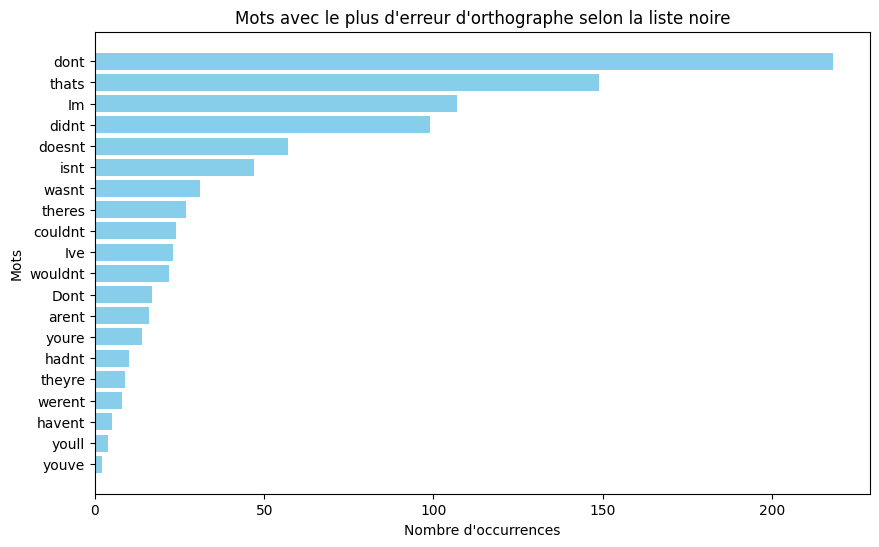

In [70]:
# Liste noire de mots à considérer comme des erreurs
blacklisted_words = {"didnt", "dont", "Im", "youre", "Ive", "doesnt", "wasnt", "couldnt", "thats", "isnt", "theres", "theyre", "wouldnt", "arent", "youll", "Dont", "youve", "havent", "hadnt", "werent"}

# Dictionnaire pour compter les occurrences des mots de la liste noire dans les textes
blacklisted_counts = {word: 0 for word in blacklisted_words}

# Parcourir chaque texte pour compter les occurrences exactes des mots de la liste noire
for text in df['text']:
    words_in_text = text.split()
    for word in blacklisted_words:
        if word in words_in_text:
            blacklisted_counts[word] += 1

# Filtrer les mots avec au moins une occurrence
filtered_counts = {word: count for word, count in blacklisted_counts.items() if count > 0}

# Trier dictionnaire par valeur pour obtenir les mots avec le plus d'occurrences
sorted_counts = sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True)

# Extraction data pour graphique
words = [word for word, count in sorted_counts]
counts = [count for word, count in sorted_counts]

# Tunning graphique 
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Mots')
plt.title('Mots avec le plus d\'erreur d\'orthographe selon la liste noire')
plt.gca().invert_yaxis()  
plt.show()

### Nuage de mots sur les réponses humaines

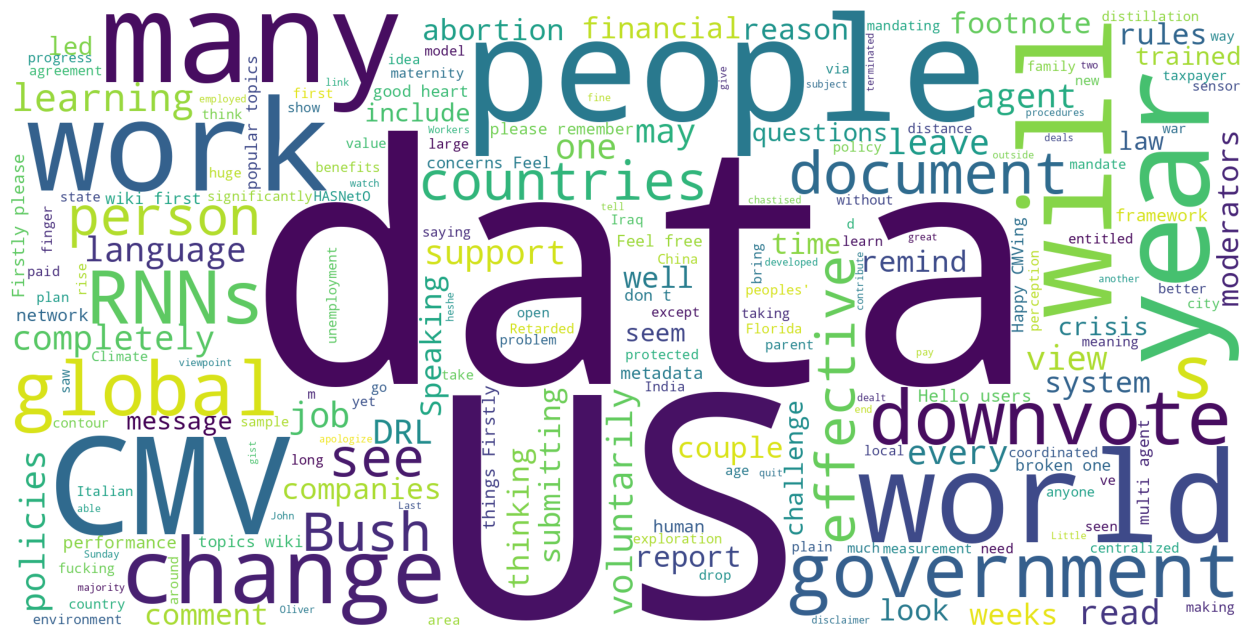

In [64]:
stopwords = set(STOPWORDS)
human = df[df['label'] == 1]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=1000, width=2000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Nuage de mots sur les réponses d'IA

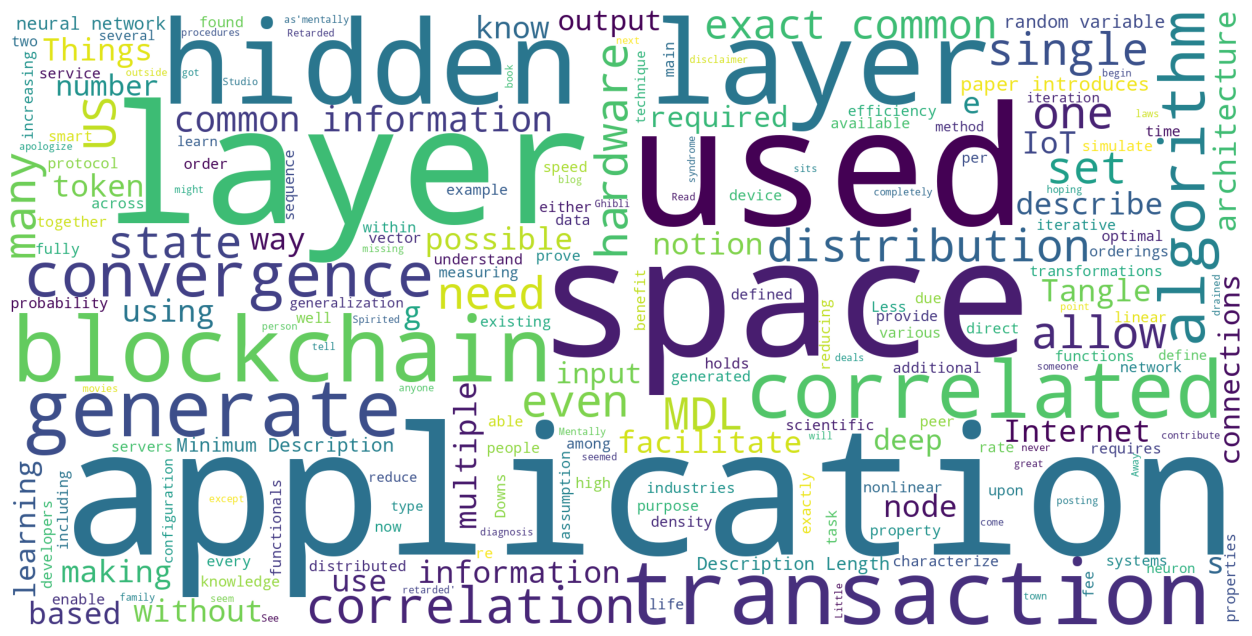

In [65]:
stopwords = set(STOPWORDS)
human = df[df['label'] == 0]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=1000, width=2000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

On observe que les mots les plus utilisés par les humains et les IAs sont très différents, avec pour les humains des mots comme "data", "us" ou "people", et pour les IAs des mots comme "application", "space" ou "layer".

### Proportion des textes entre humains et IAs

[Text(0, 0, 'humain'), Text(1, 0, 'IA')]

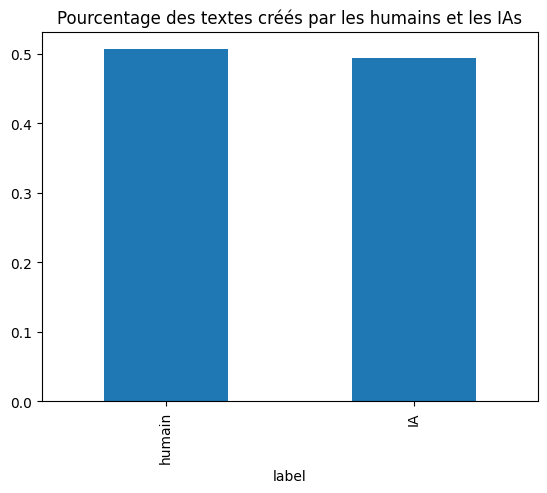

In [54]:
df.value_counts("label", normalize=True).plot(kind="bar", title= "Pourcentage des textes créés par les humains et les IAs").set_xticklabels(('humain', 'IA'))

On remarque une répartition uniforme entre les 2 différents labels, ce qui facilitera l'apprentissage des modèles.

## Benchmark de différents modèles de machine learning
---

Division du dataset en set de testing et de training, avec 80% pour le training et 20% pour le testing (qui nous sert aussi de set de validation par manque de donnée).

In [55]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# A MODIFIER
La pipeline pour les différents modèles à tester est très simple, elle consiste seulement d'un countvectorizer et du modèle. On a essayé avec des embeddings du style word2vec, fasttext, td-idf mais ca performe pas

#### Entraînement de 5 modèles de machine learning avec un grid search

In [56]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [50, 100, 200]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1.0]}
    },
    'SVC': {
        'model': SVC(),
        'params': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'model__C': [0.1, 1, 10]}
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {'model__var_smoothing': [1e-8, 1e-9, 1e-10]}
    }
}

grid_search_objects = {}
results = {}

for name, m in models.items():
    pipe = Pipeline([
        ('count_vect', CountVectorizer(stop_words='english', max_features=5000, ngram_range=(2, 2), lowercase=False)),
        ('model', m['model'])
    ])
    grid_search = GridSearchCV(pipe, m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_objects[name] = grid_search
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

for name, res in results.items():
    print(f"{name}: Meilleure précision = {res['best_score']}")
    print(f"Meilleurs paramètres : {res['best_params']}")


KeyboardInterrupt: 

#### Evaluation avec les données de tests des meilleurs modèles

In [ ]:

for name, grid_search in grid_search_objects.items():
    best_model = grid_search.best_estimator_
    
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{name} Test Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Prediction Time: {prediction_time} seconds")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


## Optimisation du meilleur modèle de machine learning
---

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear', 'poly']}
svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres trouvés via la recherche sur la grille : ", grid_search.best_params_)
print("Meilleure précision moyenne lors de la validation croisée : ", grid_search.best_score_)


In [ ]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot()
plt.show()

In [ ]:
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring = 'f1_macro', n_jobs = -1)
print("Précisions de validation croisée : ", cv_scores)
print("Précision moyenne de validation croisée : ", cv_scores.mean())

## Modèles de deep learning
---
### RNN

### RNN avec BERT

## Conclusion
---